In [67]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline  

## Import Data, Explore Types 

In [68]:
#importing data from the csv, changing the delegacion id to name of delegacion and changing headings for readability
data = pd.read_csv("Calidad.csv") 
data.replace({'delegacion_id': {1: 'Alvaro Obregon', 2: 'Azcapotzalco', 3:'Benito Juarez',4:'Coyoacan', 5:'Cuajimalpa', 6:'Cuauhtemoc', 7:'Estado de Mexico', 8: 'Gustavo A. Madero', 9:'Iztacalco', 10:'Iztapalapa', 11:'Magdalena Contreras', 12:'Miguel Hidalgo', 13:'Milpa Alta', 14:'Tlahuac', 15:'Tlalpan', 16:'Venustiano Carranza', 17:'Villa Carmela', 18:'Xochimilco'}}, inplace=True)
data.rename(index=str, columns={"average": "chlorine_avg"}, inplace=True)
data.head(3)

,id,date,neighborhood,street,num_samples,readings,chlorine_avg,num_no_cl,num_low_cl,num_rule_cl,num_excess_cl,url,delegacion_id
0,1,2019-04-02,ARBOLEDAS DEL SUR (EX-EJIDOS DE HUIPULCO),AJAX y CERRO PORTENO,1,1,0.5,0,0,1,0,http://data.sacmex.cdmx.gob.mx/aplicaciones/ca...,Tlalpan
1,2,2019-04-02,ARBOLEDAS DEL SUR (EX-EJIDOS DE HUIPULCO),BOCA JUNIORS y COSMOS,1,1,0.5,0,0,1,0,http://data.sacmex.cdmx.gob.mx/aplicaciones/ca...,Tlalpan
2,3,2019-04-02,ARBOLEDAS DEL SUR (EX-EJIDOS DE HUIPULCO),COLO COLO y DE LAS TORRES,1,1,0.4,0,0,1,0,http://data.sacmex.cdmx.gob.mx/aplicaciones/ca...,Tlalpan


In [69]:
#Data Summaries:
data.dtypes

id                 int64
date              object
neighborhood      object
street            object
num_samples        int64
readings           int64
chlorine_avg     float64
num_no_cl          int64
num_low_cl         int64
num_rule_cl        int64
num_excess_cl      int64
url               object
delegacion_id     object
dtype: object

In [70]:
#Convert date to datetime format for easier manipulation later 
data['date']=pd.to_datetime(data.date)

## Identifying and Removing Outliers 

In [71]:
#Average Chlorine level
data.chlorine_avg.describe()

count    67381.000000
mean         1.140709
std          4.383825
min          0.000000
25%          0.500000
50%          0.900000
75%          1.200000
max         73.500000
Name: chlorine_avg, dtype: float64

Text(0.5,1,'Distribution of Average Chlorine Level in Household Water Samples')

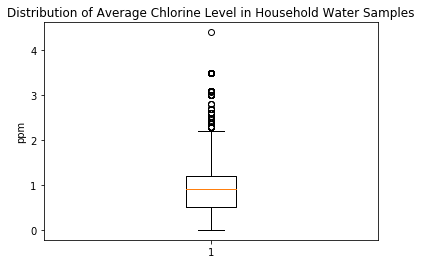

In [118]:
#Distribution of Chlorine_avg  
plt.boxplot(data.loc[:,'chlorine_avg'])
plt.ylabel('ppm')
plt.title('Distribution of Average Chlorine Level in Household Water Samples')

In [73]:
#unique values of the outliers 
data.loc[data.chlorine_avg > 5,'chlorine_avg'].unique()

array([73.5 , 37.55, 37.  , 37.35, 49.17])

In [74]:
#Number of outliers in the data 
data.loc[data.chlorine_avg > 5,'chlorine_avg'].count()

246

In [75]:
#dropping outliers
data.drop(data[data.chlorine_avg>5].index, inplace=True)

Text(0.5,1,'Distribution of Average Chlorine Level in Household Water Samples')

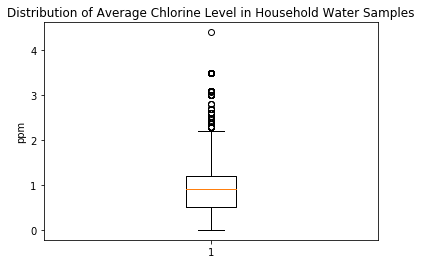

In [119]:
#New distribution of the chlorine average values without the outliers 
plt.boxplot(data.loc[:,'chlorine_avg'])
plt.ylabel('ppm')
plt.title('Distribution of Average Chlorine Level in Household Water Samples')

#### From the distbution of the chlorine levels we see that there are several outliers (246 values). The outliers are the same number and indicate that these are likely not accurate readings but some systematic glitch in data input.

## Plotting Number of Samples and Classification of Samples over Time 

#### cusory glance at the data shows that the num_readings information is often zero for rows that otherwise have data, as such the num_samples data is being ignored and each row of information is being taken as one sample

Text(0.5,1,'Number of samples taken over time')

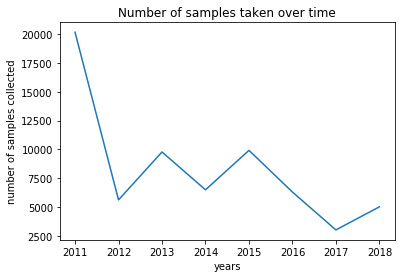

In [113]:
samples_per_year = {'year':[],'count':[]}
for year in [2011,2012,2013,2014,2015,2016,2017,2018]:
    samples_per_year['year'].append(year)
    samples_per_year['count'].append(data.loc[data['date'].dt.year == year,'chlorine_avg'].count())
    
df = pd.DataFrame(samples_per_year)
plt.plot(df.loc[:,'year'],df.loc[:,'count'])
plt.xlabel('years')
plt.ylabel('number of samples collected')
plt.title('Number of samples taken over time')

#### There is a general downward trend seen in the number of samples taken from when the program began in 2011 to the present 

In [203]:
#find how many samples were zero, below, at, or above the appropriate chlorie levels (0.2 to 1.5 ppm is used here as the cut off)

classification = {'year':[],'zero':[], 'low':[], 'good':[], 'high':[]}
for year in [2011,2012,2013,2014,2015,2016,2017,2018]:
    classification['year'].append(year)
    year_total = data.loc[(data['date'].dt.year == year),'chlorine_avg'].count()
    
    classification['zero'].append(
        (data.loc[(data['date'].dt.year == year) & (data['chlorine_avg'] == 0),'chlorine_avg'].count())/(year_total)
    )
    classification['low'].append(
        (data.loc[(data['date'].dt.year == year) & (data['chlorine_avg'] > 0) & (data['chlorine_avg'] < 0.2),'chlorine_avg'].count())/(year_total)
    )
    classification['good'].append(
        (data.loc[(data['date'].dt.year == year) & (data['chlorine_avg'] <= 1.5) & (data['chlorine_avg'] >= 0.2)].count()[0])/(year_total)
    )
    classification['high'].append(
        (data.loc[(data['date'].dt.year == year) & (data['chlorine_avg'] > 1.5),'chlorine_avg'].count())/(year_total)
    )
classification_df = pd.DataFrame(classification)

#check to see if sum is one
classification_df['sum'] = classification_df['zero'] + classification_df['low'] + classification_df['good'] + classification_df['high']
classification_df

,year,zero,low,good,high,sum
0,2011,0.026906,0.007397,0.950109,0.015588,1.0
1,2012,0.071594,0.013679,0.884171,0.030556,1.0
2,2013,0.079771,0.016772,0.870117,0.033340,1.0
3,2014,0.078733,0.017377,0.844687,0.059203,1.0
4,2015,0.080250,0.017240,0.849481,0.053030,1.0
5,2016,0.088762,0.023934,0.844508,0.042796,1.0
6,2017,0.095018,0.019795,0.840977,0.044210,1.0
7,2018,0.141523,0.014908,0.793480,0.050089,1.0


Text(0,0.5,'Chlorine Level (ppm)')

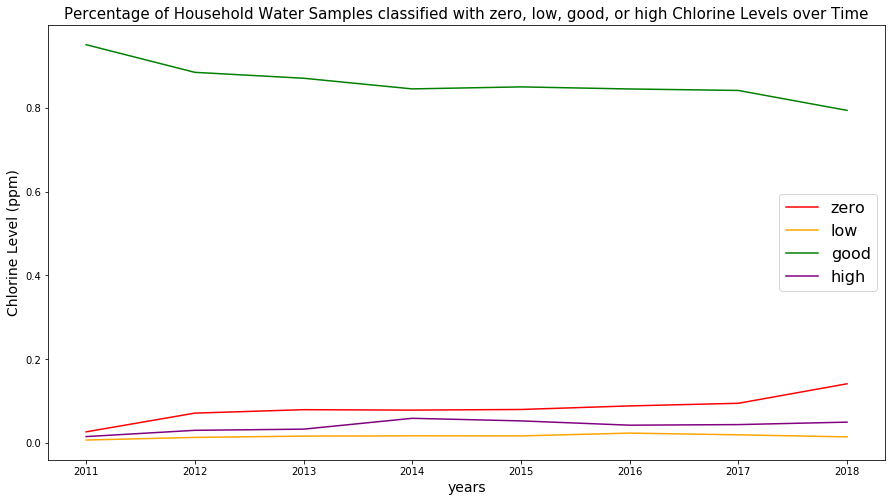

In [209]:
plt.figure(figsize=(15,8))
plt.plot(classification_df.year, classification_df.zero, color='red')
plt.plot(classification_df.year, classification_df.low, color='orange')
plt.plot(classification_df.year, classification_df.good, color='green')
plt.plot(classification_df.year, classification_df.high, color='purple')
plt.legend(fontsize = 16)
plt.title('Percentage of Household Water Samples classified with zero, low, good, or high Chlorine Levels over Time', fontsize = 15)
plt.xlabel('years', fontsize = 14)
plt.ylabel('Chlorine Level (ppm)', fontsize = 14)


#### We can see that the percentage of samples that are classified within the appropraite level are dropping while the number of samples with no chlorine are increasing. The high and low levels appear to be fairly stagnant. It appears that the drop in samples in good range is being accounted for in the number of samples that don't have any chlorine at all which is of concern. Further exploration of wheather the drop in appropriately chlorinatd water is happening across all the delegacions or more steeply in certain locals is worth looking into. 